In [1]:
import json
import numpy as np
import os
import cv2
import copy
import random
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import cos, sin, atan2, sqrt

In [16]:
lnmk_names = ['jaw', 'left eye', 'right eye', 'nose', 'mouth']
labels = ['HarDNet', 
          '1. Mobilenext',
          '2. Mobilenext',
          '3. Mobilenext',
          '4. Mobilenext',
          '5. Mobilenext']
colors = ['gold', 
          'tab:gray', 
          'tab:gray', 
          'tab:blue', 
          'tab:red',
          'tab:green']
accuracies = [[0.85, 0.89, 0.89, 0.93, 0.93],
              [0.5, 0.43, 0.49, 0.525, 0.4],
              [0.53, 0.633, 0.62, 0.7, 0.56],
              [0.56, 0.66, 0.63, 0.69, 0.58],
              [0.69, 0.76, 0.76, 0.81, 0.66],
              [0.72, 0.77, 0.78, 0.82, 0.7],
             ]


Text(0, 0.5, 'Accuracy')

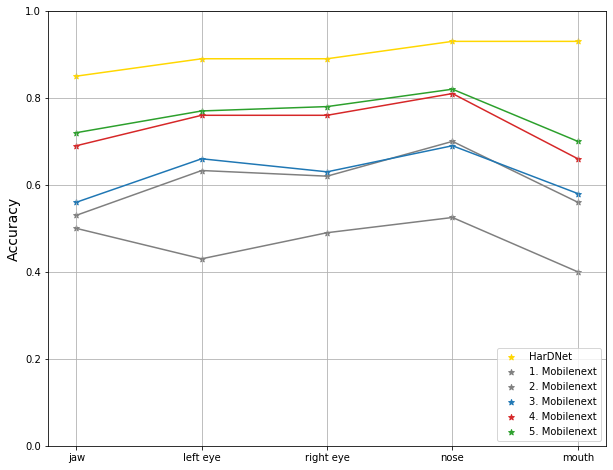

In [17]:
fig = plt.figure(figsize=(10, 8))
for label, accuracy, clc in zip(labels, accuracies, colors):
    for i, (acc, lnmk_name) in enumerate(zip(accuracy, lnmk_names)):
        if i == 0:
            plt.scatter(lnmk_name, acc, marker="*", color= clc, label = label)
        else:
            plt.scatter(lnmk_name, acc, marker="*", color= clc)
    plt.plot(lnmk_names, accuracy, color= clc)
plt.grid()
plt.legend(loc = 'lower right')
plt.ylim([0., 1])
plt.ylabel('Accuracy', fontsize = 14)

In [2]:
param_path = "/aidata/anders/data_collection/okay/total/analyze/params.npy"
params = np.load(param_path)


In [21]:
def matrix2angle(R):
    ''' get three Euler angles from Rotation Matrix
    Args:
        R: (3,3). rotation matrix
    Returns:
        x: pitch
        y: yaw
        z: roll
    '''
    sy = sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6
    if not singular:
        x = atan2(R[2, 1], R[2, 2])
        y = atan2(-R[2, 0], sy)
        z = atan2(R[1, 0], R[0, 0])
    else:
        x = atan2(-R[1, 2], R[1, 1])
        y = atan2(-R[2, 0], sy)
        z = 0
    # rx, ry, rz = np.rad2deg(x), np.rad2deg(y), np.rad2deg(z)
    # rx, ry, rz = x * 180 / np.pi, y * 180 / np.pi, z * 180 / np.pi
    # return rx, ry, rz
    return x, y, z

pitches, yaws, rolls = [], [], []
for param in tqdm(params):
    R = param[:9]
    shp = param[9:49]
    exp = param[49:-3]
    t3d = param[-3:]
    R = R.reshape([3, 3])
    angels = matrix2angle(R)
    angels = np.asarray(angels) * (180 / np.pi)
    pitch, yaw, roll = angels
    if pitch < 0:
        pitch = -(180 + pitch)
    elif pitch > 0:
        pitch = (180 - pitch)
    pitches.append(pitch)
    yaws.append(yaw)
    rolls.append(roll)
    
    
pitches = np.asarray(pitches)
yaws = np.asarray(yaws)
rolls = np.asarray(rolls)
param_mean = np.mean(params[:, :-3], axis = 0)
param_std = np.std(params[:, :-3], axis = 0)

100%|██████████| 29886/29886 [00:00<00:00, 184536.68it/s]


In [4]:
from scipy import optimize as op
def fitting_funs(bins, n):
    def f(x, mu, sigma):
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (x - mu))**2))
        return y
    mu, sigma = op.curve_fit(f, bins[1:], n)[0]
    fitted_y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    return fitted_y, mu, sigma

/home2/anders/miniconda3/envs/anders_torch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 0, 'Pose angle')

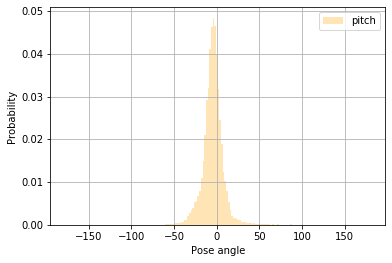

In [43]:
N,  = np.shape(pitches)
idxs = np.arange(N)
fig, ax = plt.subplots()
pitch_n, pitch_bins, _  = ax.hist(pitches, density=True, color="moccasin", bins=180, label = "pitch")
fitting_pitch, _, _ = fitting_funs(pitch_bins, pitch_n)
plt.grid()
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Pose angle')

Text(0.5, 0, 'Pose angle')

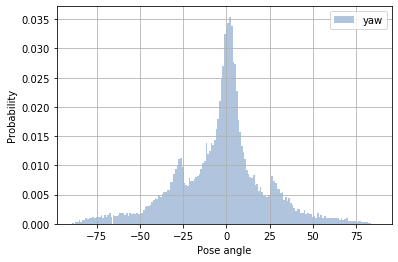

In [45]:
fig, ax = plt.subplots()
yaw_n, yaw_bins, _  = ax.hist(yaws, density=True, color="lightsteelblue", bins=180, label = "yaw")
fitting_yaw, _, _ = fitting_funs(yaw_bins, yaw_n)
plt.grid()
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Pose angle')

Text(0.5, 1.0, 'Channel 31')

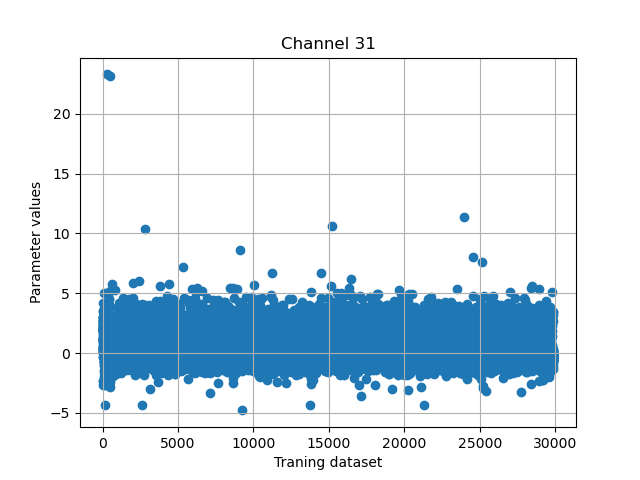

In [35]:
Z_params = (params[:, :-3] - param_mean[None, :]) / param_std[None, :]
fig, ax = plt.subplots()
Z_params_T = Z_params.T
N = np.arange(Z_params.shape[0])
ax.scatter(N, Z_params_T[30, :])
plt.grid()
plt.ylabel('Parameter values')
plt.xlabel('Traning dataset')
plt.title('Channel 31')
# ax.plot(Z_params[:, 2], color="lightsteelblue", label = "Z")

<ipython-input-23-0d87acd83730>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


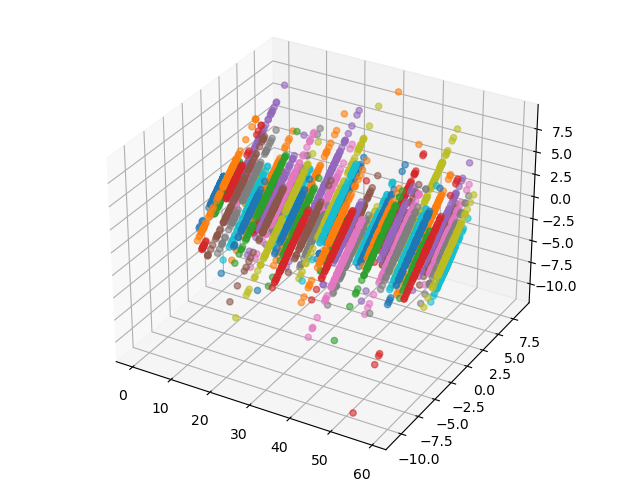

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib widget
N = Z_params.shape[0]
idxs = np.arange(N)

fig = plt.figure()
ax = Axes3D(fig)
Z_params = Z_params.T
for i, Z_param in enumerate(Z_params):
    plot_geeks = ax.scatter(i, Z_param[:100],  Z_param[:100], alpha = 0.6)
    